In [1]:
!pip install tqdm
!pip install nltk

### **Load Packages**

In [2]:
# Paths
import os
import string
from os import listdir
import numpy as np
from numpy import argmax
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Load and Save
from pickle import load, dump

# Progress Bar
from tqdm.notebook import tqdm
from collections import Counter

# Deep Learning Stack
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, Dropout, concatenate

# Evaluation Metric
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### **Pretrained Model**

In [3]:
# Define the pre-trained model
pretrained_model = VGG19(
    weights='imagenet', 
    include_top=True
)

# Freezing output layers
VGG19_model = Model(pretrained_model.input, pretrained_model.layers[-2].output)
VGG19_model.trainable = False

# Model Summary
VGG19_model.summary()

574710816/574710816 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
VGG19_model.save('/kaggle/working/base_model_VGG19')

### **Load Images**

In [5]:
features = {}
img_dir = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset'
img_list = os.listdir(img_dir)

for img in tqdm(img_list):

    # Load the image from directory
    img_path = os.path.join(img_dir, img)
    image = load_img(img_path, target_size=(224,224))

    # Convert image pixels to numpy array
    image_array = img_to_array(image)
    images = np.expand_dims(image_array, axis=0)

    # Reshape data for model
    images = images.reshape((1, image_array.shape[0], image_array.shape[1], image_array.shape[2]))

    # Preprocess image
    images = preprocess_input(images)

    # Extract features 
    feature = VGG19_model.predict(images, verbose=0)

    # Remove .jpeg 
    img_id = img.split('.')[0]

    # Storing features of images
    features[img_id] = feature

dump(features, open('/kaggle/working/features.pkl', 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

### **GPU Setting**

In [6]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)
# with strategy.scope():
#   inputs = tf.keras.layers.Input(shape=(1,))
#   predictions = tf.keras.layers.Dense(1)(inputs)
#   model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
#   model.compile(loss='mse',
#                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

In [7]:
def load_data_set_ids(filename):
    """
    The ids of the image belonging to each dataset 
    is stored in a text file. The following function 
    loads the image ids for each data sets.
    """
    file = open(filename, 'r')
    text = file.read()
    file.close()
    
    dataset = list()
    for image_id in text.split('\n'):
        if len(image_id) < 1:
            continue
            
        dataset.append(image_id)
    
    return set(dataset)

In [8]:
train_set = load_data_set_ids('/kaggle/input/flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt')
val_set = load_data_set_ids('/kaggle/input/flickr8k/Flickr8k_text/Flickr_8k.devImages.txt')
test_set = load_data_set_ids('/kaggle/input/flickr8k/Flickr8k_text/Flickr_8k.testImages.txt')

### **Load Captions**

In [9]:
filename = '/kaggle/input/flickr8k/Flickr8k_text/Flickr8k.token.txt'
file = open(filename, 'r')
token_text = file.read()
file.close()

In [10]:
#translation table that maps all punctuations
translator = str.maketrans('', '', string.punctuation) 
img_captions = {}
img_captions_train = {}
img_captions_val = {}
img_captions_test = {}
img_captions_other = {}

#bag of words
corpus = []

# Representing start and and end of sentence in the corpus
corpus.extend(['<-START->', '<-END->', '<-UNK->'])

In [11]:
max_length = 0

# First split on new line
for line in token_text.split('\n'): 
    tokens = line.split(' ') # Split on white space
    if len(line) < 2:
        continue
    img_id, img_cap = tokens[0], tokens[1:] # Use the first segment as image id, the rest as caption
    img_id = img_id.split('#')[0] # Strip out from filename
    img_cap = ' '.join(img_cap) # Join image caption together again

    img_cap = img_cap.lower() # Change to lower case
    img_cap = img_cap.translate(translator) # Take out punctuation using a translation table
    
    img_cap = img_cap.split(' ') # Split string here because following two methods works on word-level best
    img_cap = [w for w in img_cap if w.isalpha()] # keep only words that are all alphabets
    img_cap = [w for w in img_cap if len(w)>1]
    img_cap = '<-START-> ' + ' '.join(img_cap) + ' <-END->'
    
    # Update maximum caption length
    if len(img_cap.split()) > max_length:
        max_length = len(img_cap.split())
    
    # Add to dictionary
    if img_id not in img_captions:
        img_captions[img_id] = list() # Create a new list if it does not yet exist
    img_captions[img_id].append(img_cap)
    
    # Add to train/dev/test dictionaries
    if img_id in train_set:
        if img_id not in img_captions_train:
            img_captions_train[img_id] = list() # Create a new list if it does not yet exist
        img_captions_train[img_id].append(img_cap)
        corpus.extend(img_cap.split()) # add only training words to corpus to train tokenlizer
        
    elif img_id in val_set:
        if img_id not in img_captions_val:
            img_captions_val[img_id] = list() #Create a new list if it does not yet exist
        img_captions_val[img_id].append(img_cap)
        
    elif img_id in test_set:
        if img_id not in img_captions_test:
            img_captions_test[img_id] = list() #Create a new list if it does not yet exist
        img_captions_test[img_id].append(img_cap)
    else:
        if img_id not in img_captions_other:
            img_captions_other[img_id] = list() #Create a new list if it does not yet exist
        img_captions_other[img_id].append(img_cap)

In [12]:
# Initialize tokenizer
cap_train_tokenizer = Tokenizer()
# Fit tokenizer
cap_train_tokenizer.fit_on_texts(corpus) 

In [13]:
file_id = open("img_captions.pkl","wb")
dump(img_captions, file_id)
file_id.close()

file_id = open("img_captions_train.pkl","wb")
dump(img_captions_train, file_id)
file_id.close()

file_id = open("img_captions_val.pkl","wb")
dump(img_captions_val, file_id)
file_id.close()

file_id = open("img_captions_test.pkl","wb")
dump(img_captions_test, file_id)
file_id.close()

file_id = open("img_captions_other.pkl","wb")
dump(img_captions_other, file_id)
file_id.close()

file_id = open("cap_train_tokenizer.pkl","wb")
dump(cap_train_tokenizer, file_id)
file_id.close()

file_id = open("corpus.pkl","wb")
dump(corpus, file_id)
file_id.close()

corpus_count=Counter(corpus)
file_id = open("corpus_count.pkl","wb")
dump(corpus_count, file_id)
file_id.close()

In [14]:
display(print(f"Size of total data: {len(img_captions)}"))
display(print(f"Size of training data: {len(img_captions_train)}"))
display(print(f"Size of val data: {len(img_captions_val)}"))
display(print(f"Size of test data: {len(img_captions_test)}"))
display(print(f"Maximum length of captions:{max_length}"))

Size of total data: 8092


None

Size of training data: 6000


None

Size of val data: 1000


None

Size of test data: 1000


None

Maximum length of captions:33


None

### **Pretrained Word GloVE Embeddings**

In [15]:
# Instead of training the word embeddings, we will use the pretrained GloVE word embeddings
embeddings_index = {}
file_id = open('/kaggle/input/glove/glove.6B.50d.txt' ,encoding="utf8")
for line in file_id:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file_id.close()

In [16]:
EMBEDDING_DIM = 50
word_index = cap_train_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embed_vector
        
file_id = open("embedding_matrix.pkl","wb")
dump(embedding_matrix, file_id)
file_id.close()

### **Progressive Loading**
n, n+1, n+2,....

In [17]:
def create_sequence(tokenizer, max_length, desc_list, photo, vocab_size):
    """
    Creates sequence in form of progressive 
    loading .i.e n,n+1,n+2,n+3
    """
    X1, X2, y = list(), list(), list()
    # Walk through each description for the image
    for desc in desc_list:
        # Encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0] #[0] is used to take out the extra dim. This changes from text to a number
        # Split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # Split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # Pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # Encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(np.squeeze(X1)), np.array(X2), np.array(y)

In [18]:
def data_generator(descriptions, photos, tokenizer, max_length, batch_size, vocab_size):
    # loop for ever over images
    current_batch_size=0
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            if current_batch_size == 0:
                X1, X2, Y = list(), list(), list()
            
            imageFeature_id = key.split('.')[0]
            photo = photos[imageFeature_id][0]
            in_img, in_seq, out_word = create_sequence(tokenizer, max_length, desc_list, photo, vocab_size)
            #in_img = np.squeeze(in_img)
            X1.extend(in_img)
            X2.extend(in_seq)
            Y.extend(out_word)
            current_batch_size += 1
            if current_batch_size == batch_size:
                current_batch_size = 0
                yield [[np.array(X1), np.array(X2)], np.array(Y)]

In [19]:
file_id = open('features.pkl', 'rb')
image_features = load(file_id)
file_id.close()

# test the data generator
caption_max_length = 33
batch_size = 1
vocab_size = 7057
generator = data_generator(img_captions_train, image_features, cap_train_tokenizer, caption_max_length, batch_size, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(47, 4096)
(47, 33)
(47, 7057)


### **Deep Model Creation**

In [20]:
def model_concat(vocab_size, max_length, embedding_matrix):
    """
    CNN(Images) + GloVE Embedding + RNN(LSTM)
    """
    # Feature extractor model
    inputs1 = Input(shape=(4096,))
    image_feature = Dropout(0.5)(inputs1)
    image_feature = Dense(256, activation='relu')(image_feature)
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    language_feature = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs2)
    language_feature = Dropout(0.5)(language_feature)
    language_feature = LSTM(256)(language_feature)
    # Decoder model
    output = concatenate([image_feature, language_feature])
    output = Dense(256, activation='relu')(output)
    output = Dense(vocab_size, activation='softmax')(output)
    # Concatenation
    model = Model(inputs=[inputs1, inputs2], outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    print(model.summary())
    plot_model(model, to_file='model_concat.png', show_shapes=True)
    return model

In [21]:
file_id = open("embedding_matrix.pkl","rb")
embedding_matrix = load(file_id)
file_id.close()

caption_max_length = 33
vocab_size = 7506
rnn_model_concat = model_concat(vocab_size, caption_max_length, embedding_matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 50)       375300      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

### **Train Model**

In [22]:
file_id = open("features.pkl","rb")
image_features = load(file_id)
file_id.close()

file_id = open("cap_train_tokenizer.pkl","rb")
caption_train_tokenizer = load(file_id)
file_id.close()

file_id = open("img_captions_train.pkl","rb")
img_captions_train = load(file_id)
file_id.close()

file_id = open("img_captions_val.pkl","rb")
img_captions_val = load(file_id)
file_id.close()

epochs = 5
caption_max_length = 33
vocab_size = 7506
batch_size = 14

steps = len(img_captions_train)
steps_per_epoch = np.floor(steps/batch_size)

for i in range(epochs):
    # Create the data generator
    generator = data_generator(
        img_captions_train, 
        image_features, 
        caption_train_tokenizer, 
        caption_max_length, 
        batch_size, 
        vocab_size
    )
    # Fit model
    rnn_model_concat_hist=rnn_model_concat.fit(
        generator, 
        epochs=1, 
        steps_per_epoch=steps, 
        verbose=1
    )
    # Save model
    rnn_model_concat.save('RNN_model_Concat_1_' + str(i) + '.h5')

6000/6000 [==============================] - 4166s 694ms/step - loss: 2.2048 - acc: 0.4330


### **FC Layer of VGG19 for Captions**

In [24]:
feature_extract_pred_model = Model(inputs=VGG19_model.input, outputs=VGG19_model.get_layer('fc2').output)

In [25]:
def extract_feature(model, file_name):
    img = load_img(file_name, target_size=(224, 224))
    # Change img to np array
    x = img_to_array(img)
    # Expand to include batch dim at the beginning
    x = np.expand_dims(x, axis=0) 
    # Preprocess Images with VGG19
    x = preprocess_input(x) 
    fc2_features = model.predict(x)
    return fc2_features

In [26]:
# Load the tokenizer
caption_train_tokenizer = load(open('cap_train_tokenizer.pkl', 'rb'))
# Pre-define the max sequence length (from training)
max_length = 33
# Load the model
pred_model = load_model('RNN_model_Concat_1_0.h5')

In [27]:
def generate_caption(pred_model, caption_train_tokenizer, photo, max_length):
    """
    To generate the caption, we first initialize the caption 
    with the "START" token. We then input the caption into 
    the model, which will output the next word in the caption. 
    The generated word will be appended to the end of the 
    caption and fed back into the model. The iterative process
    stops when the "end" token is received.
    """
    in_text = '<-START->'
    captions = list()
    for i in range(max_length):
            # integer encode input sequence
            sequence = caption_train_tokenizer.texts_to_sequences([in_text])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next word
            model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
            # convert probability to integer
            word_index = argmax(model_softMax_output)
            # map integer to word
            word = caption_train_tokenizer.index_word[word_index]
            #print(word)
            # stop if we cannot map the word
            if word is None:
                break
            # append as input for generating the next word
            in_text += ' ' + word
            # stop if we predict the end of the sequence
            if word != 'end':
                captions.append(word)
            if word == 'end':
                break
    return captions

### **Caption Evaluation**

In [28]:
file_id = open("features.pkl","rb")
image_features = load(file_id)
file_id.close()

file_id = open("cap_train_tokenizer.pkl","rb")
cap_train_tokenizer = load(file_id)
file_id.close()

file_id = open("img_captions_test.pkl","rb")
img_captions_test = load(file_id)
file_id.close()

# Pre-define the max sequence length (from training)
max_length = 33
# Load the model
pred_model = load_model('RNN_model_Concat_1_2.h5')

# Define the image feature extraction model
feature_extract_pred_model = Model(inputs=VGG19_model.input, outputs=VGG19_model.get_layer('fc2').output)

In [29]:
image_captions_candidate = {}

for image_fileName, reference_captions in tqdm(img_captions_test.items()):
    image_fileName_feature = image_fileName.split('.')[0]
           
    photo = features[image_fileName_feature]
    image_captions_candidate[image_fileName] = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
    
with open("test_captions_post_concat","wb") as file_id:
    dump(image_captions_candidate, file_id)

  0%|          | 0/1000 [00:00<?, ?it/s]

### **BLEU Evaluation Metrics**

In [30]:
file_id = open("test_captions_post_concat","rb")
image_captions_candidate = load(file_id)
file_id.close()

file_id = open("img_captions_test.pkl","rb")
image_captions_test = load(file_id)
file_id.close()

smoothing = SmoothingFunction()

bleu_score = dict()
for image_fileName, reference_captions in image_captions_test.items():
    ref_cap_reformat=list()
    for cap in reference_captions:
        ref_cap_reformat.append(cap.split()[1:-1])
    
    bleu_score[image_fileName] = sentence_bleu(
        ref_cap_reformat, 
        image_captions_candidate[image_fileName], 
        smoothing_function=smoothing.method1
    )
    
bleu_score_array = np.fromiter(bleu_score.values(), dtype=float)

print(f'Mean bleu: {round(np.mean(bleu_score_array), 4)}')
print(f'Median bleu: {round(np.median(bleu_score_array), 4)}')
print(f'Max bleu: {round(np.max(bleu_score_array), 4)}')
print(f'Min bleu: {round(np.min(bleu_score_array), 4)}')
print(f'Std bleu: {round(np.std(bleu_score_array), 4)}')

Mean bleu: 0.0925
Median bleu: 0.0587
Max bleu: 0.8187
Min bleu: 0.0
Std bleu: 0.1042


### **Generate Captions**

1/1 [==============================] - 0s 362ms/step
white dog is running through the snow


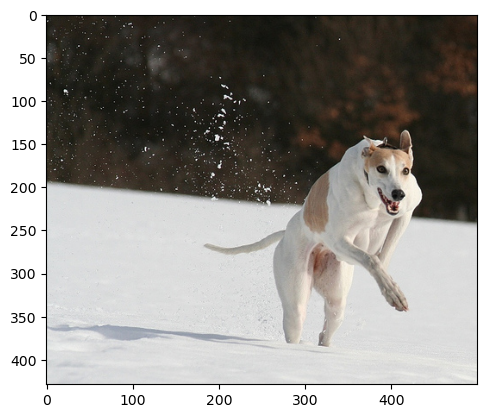

In [33]:
caption_image_fileName = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))

# Load image
image = plt.imread(caption_image_fileName)

# Display image
plt.imshow(image)
plt.show()

1/1 [==============================] - 0s 381ms/step
man is sitting on snowy hill


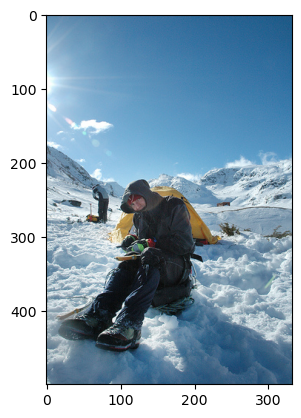

In [34]:
caption_image_fileName = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/116409198_0fe0c94f3b.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))

# Load image
image = plt.imread(caption_image_fileName)

# Display image
plt.imshow(image)
plt.show()

1/1 [==============================] - 1s 691ms/step
elderly man wearing hat and hat is sitting on the bench


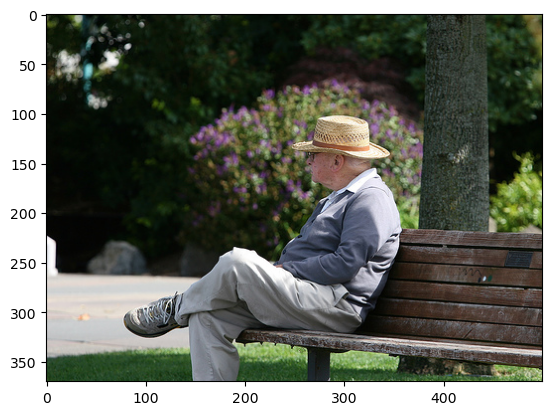

In [60]:
caption_image_fileName = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1160034462_16b38174fe.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))

# Load image
image = plt.imread(caption_image_fileName)

# Display image
plt.imshow(image)
plt.show()

1/1 [==============================] - 0s 425ms/step
young boy is running through the water


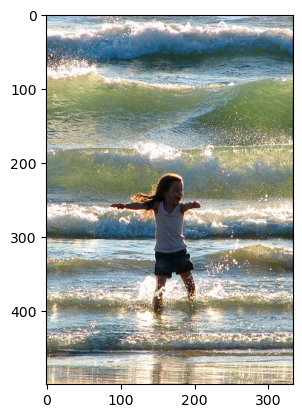

In [62]:
caption_image_fileName = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/1151466868_3bc4d9580b.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))

# Load image
image = plt.imread(caption_image_fileName)

# Display image
plt.imshow(image)
plt.show()

1/1 [==============================] - 0s 421ms/step
rock climbers climb sheer rock face


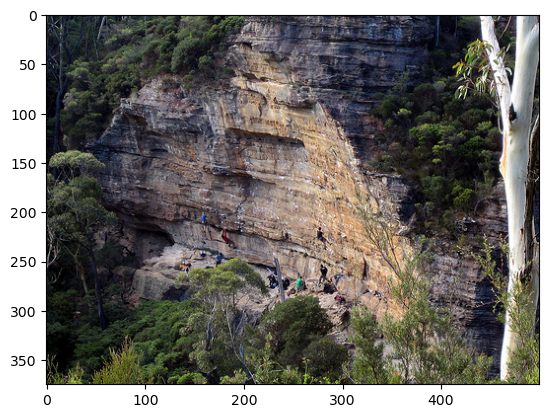

In [63]:
caption_image_fileName = '/kaggle/input/flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/121800200_bef08fae5f.jpg'
photo = extract_feature(feature_extract_pred_model, caption_image_fileName)
caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
print(' '.join(caption))

# Load image
image = plt.imread(caption_image_fileName)

# Display image
plt.imshow(image)
plt.show()